# Validate method for calculating non-compliance 
Su Kyong validated her python script for calculating non-compliance by running the matlab script provided by the DOE and comparing the output from this matlab script to the values created from her python script.  I asked her for the spreadsheet with values from the matlab script so that I can compare these numbers to mine.  She assured me that she will look for it and will provide it if/when she finds it.

In the meantime, the DOE provides values of Area Noncompliant and Max Days Noncompliant.  In this notebook, I use the method that I developed for calculating area and days non-compliant and compare my calculations of area non-compliant with max days non-compliant.  I also compare my values with those given by Su Kyong. 

RESULT:
- The area estimate with units km^2 is incorrect in the shapefile that I was using.  I've corrected this mistake by using the value in units of m^2 and converting this value to km^2.
- Out[21] shows that my non-compliance days for a handfull of nodes is identical to Su Kyong's
- In the section "Calculate values with/without rounding and with different human allowances" I provide a few different estimates of area and max days non-compliant, for methods with/without rounding and with different values of human allowance

In [1]:
import sys
import os
sys.path.insert(1, '../scripts/')
import xarray
import openpyxl
import contextily as cx 
import yaml
import numpy as np
import pandas
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
# load functions from my scripts file "ssm_utils"
from ssm_utils import get_nearest_node, reshape_fvcom, calc_fvcom_stat, extract_fvcom_level

### Define study focus and analysis scope 
- scope: wc for water column or benthic for bottom-level

In [2]:
case = "SOG_NB"
scope= "wc" # "benthic" or "wc"
model_var='DOXG' 
dir_list = ["wqm_baseline", "wqm_reference"]
run_dir = dir_list[0]
non_compliant_threshold=-0.25

### Load configuration file (yaml) and shapefile

In [3]:
with open(f'../etc/SSM_config_{case}.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# get shapefile path    
shp = ssm['paths']['shapefile']
# load shapefile into geopandas dataframe
gdf = gpd.read_file(shp)
gdf = gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()
regions.remove('Other')
# Get path for model output
processed_netcdf_dir = pathlib.Path(ssm['paths']['processed_output'])/case/model_var

In [4]:
gdf.shape

(16012, 24)

In [5]:
# Initialize dictionaries
MinDO_full={} # Min, daily DO over all nodes
MinDO={} # Min, daily DO over all nodes in shapefile
DO_diff_lt_0p2={} # Boolean where DO<threshold
DO_diff_lt_0p2_days={} # Number of days where DOBelowThresh = True
DaysNonCompliant={} # Sum of days across regions
VolumeDaysNonCompliant={} # Percent of volume within region where DO<threshold
PercentVolumeDaysNonCompliant={}
AreaNonCompliant={}

In [6]:
for run_dir in dir_list: 
    try: 
        run_file=processed_netcdf_dir/run_dir/'wc'/f'daily_min_{model_var}_wc.nc'
        with xarray.open_dataset(run_file) as ds:
            print([*ds])
            MinDO_full[run_dir]=ds[f'{model_var}_daily_min_wc']
            # Sub-sample nodes (from 16012 nodes to 7494)
            MinDO[run_dir]=MinDO_full[run_dir][:,:,gdf['node_id']-1]
            print(MinDO[run_dir].shape)
    except FileNotFoundError:
        print(f'File Not Found: {run_file}')
    if run_dir == dir_list[0]:
        # Get number of days and nodes
        [ndays,nlevels,nnodes]=MinDO[run_dir].shape

        # Convert DO_standard to 3D array (time, depth, nodes) for Part B noncompliance calc
        DO_std = np.tile(gdf.DO_std,(ndays,nlevels,1))
        unmasked = np.tile(gdf.included_i, (ndays,nlevels,1))

['DOXG_daily_min_wc']
(361, 10, 16012)
['DOXG_daily_min_wc']
(361, 10, 16012)


In [7]:
volume = np.asarray(gdf.volume)
depth_fraction = np.array(ssm['siglev_diff'])/100
volume2D = np.dot(volume.reshape(nnodes,1),depth_fraction.reshape(1,nlevels))
# Define reference run
reference = ssm['run_information']['reference']
print(reference)
dir_list.remove(reference)

wqm_reference


# Calculate non-compliance for 2014 Conditions

In [8]:
run_type = "wqm_baseline"
DO_diff = MinDO[run_type] - MinDO[reference]

In [9]:
# Boolean where DO_diff < -0.2 (or non_compliant_threshold value)
#DO_diff_lt_0p2[run_type] = DO_diff<=non_compliant_threshold #361x4144 (nodes x time) or 361x10x4144
#DO_diff_lt_0p2[run_type] = DO_diff<=non_compliant_threshold  #361x4144 (nodes x time) or 361x10x4144
# Part-B Noncompliance:
# - Min DO for reference case < DO standard + human limit (0.2 mg/l) and 
# - DO difference between case and reference is less than threshold (-0.2 or -0.25 for "rounding method")

print('Size MinDO: ', MinDO[reference].shape)
print('size gdf: ', unmasked.shape)
DO_diff_lt_0p2[run_type] = (
    (DO_diff<=non_compliant_threshold) &   #361x4144 (nodes x time) or 361x10x4144
    (MinDO[reference] < DO_std + 0.2) &
    (unmasked==1)
)
df_daysnoncompliant = DO_diff_lt_0p2[run_type].max(axis=1).sum(axis=0)

Size MinDO:  (361, 10, 16012)
size gdf:  (361, 10, 16012)


## Compare these values with 2021 optimization report: 
- Max noncompliance day: 159
- Noncompliance area [km2]: 320

In [10]:
Days_noncompliant=DO_diff_lt_0p2[run_type].max(axis=1).sum(axis=0)
print('Maximum Days Non-compliant: ', Days_noncompliant.max().item())

Maximum Days Non-compliant:  163


In [11]:
AreaNonCompliant=np.asarray(DO_diff_lt_0p2[run_type].max(axis=1).max(axis=0)*gdf.Area_km2)
idx = (gdf['included_i']==1)
print('Area non-compliant [km2]: ', AreaNonCompliant[idx].sum().item())

Area non-compliant [km2]:  775.8491629873216


# Add area non-compliant to gdf

In [12]:
gdf['AreaNonCompliant']=AreaNonCompliant

# Calculate noncompliance for 2014 without adding human allowance to DO_std

In [13]:

DO_diff_lt_0p2[run_type] = (
    (DO_diff<=non_compliant_threshold) &   #361x4144 (nodes x time) or 361x10x4144
    (MinDO[reference] < DO_std) &
    (unmasked==1)
)
Days_noncompliant=DO_diff_lt_0p2[run_type].max(axis=1).sum(axis=0)
print('Maximum Days Non-compliant: ', Days_noncompliant.max().item())
AreaNonCompliant=np.asarray(DO_diff_lt_0p2[run_type].max(axis=1).max(axis=0)*gdf.Area_km2)
idx = (gdf['included_i']==1)
print('Area non-compliant [km2]: ', AreaNonCompliant[idx].sum().item())

Maximum Days Non-compliant:  161
Area non-compliant [km2]:  773.9532978488886


# Show area non-compliant (i.e. non-zero) to make sure that I'm only adding area values where non-compliant

In [14]:
# print number of nodes with area compliant
print('Number of compliant nodes: ', len(gdf['AreaNonCompliant'][gdf['AreaNonCompliant']==0]))
print('Number of non-compliant nodes: ', len(gdf['AreaNonCompliant'][gdf['AreaNonCompliant']>0]))

Number of compliant nodes:  15366
Number of non-compliant nodes:  646


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

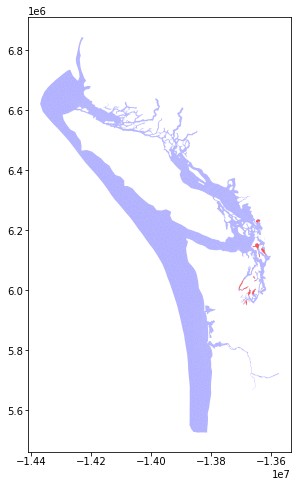

In [15]:
gdf_noncompliant = gdf.loc[
    (gdf['AreaNonCompliant']>0)
]
gdf_good = gdf.loc[
    (gdf['AreaNonCompliant']==0)
]
fig, axs = plt.subplots(1,1, figsize = (8,8))
#~~~ Non-compliant (red) and Compliant (blue) nodes ~~~
gdf_good.plot(ax=axs,color='blue',legend=True,
                 label='Compliant', alpha=0.3)
gdf_noncompliant.plot(ax=axs,color='red',legend=True,
                 label=f'Non-compliant ($\Delta$DO < 0.25)')

### Zoom into South Salish Sea region

(5900000.0, 6250000.0)

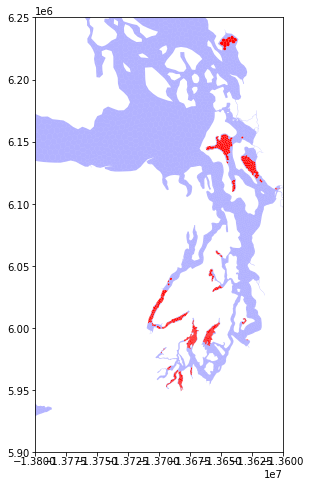

In [16]:
fig, axs = plt.subplots(1,1, figsize = (8,8))
#~~~ Non-compliant (red) and Compliant (blue) nodes ~~~
gdf_good.plot(ax=axs,color='blue',legend=True,
                 label='Compliant', alpha=0.3)
gdf_noncompliant.plot(ax=axs,color='red',legend=True,
                 label=f'Non-compliant ($\Delta$DO < 0.25)')
axs.set_xlim([-1.38e7,-1.36e7])
axs.set_ylim([5.9e6, 6.25e6])

### This looks right to me!  Frusterating.....

# Compare these regions to those in [Su Kyong's spreadsheet](https://uwnetid.sharepoint.com/:x:/r/sites/og_uwt_psi/_layouts/15/Doc.aspx?sourcedoc=%7B176658EC-AA9F-4DC1-879F-E51C30805DFD%7D&file=noncompliance_calc_baseline.xlsx&action=default&mobileredirect=true)

In [17]:
sknc_xlsx = '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/spreadsheets/noncompliance_calc_baseline.xlsx'
sknc_df=pandas.read_excel(sknc_xlsx,sheet_name="case2")

In [18]:
# First, compare the Areas
area_diff = sknc_df.area - gdf.Area_km2
print("Difference between the areas used in Su Kyong's area non-compliant calculations and Kevin's shapefile")
print('Maximum difference: ', area_diff.max())
print('Sum of differences: ', area_diff.sum())

Difference between the areas used in Su Kyong's area non-compliant calculations and Kevin's shapefile
Maximum difference:  159.3442829025
Sum of differences:  -87909.47187805359


In [19]:
# Check to see if nodes are the same
node_diff = sknc_df.node_id - gdf.tce
print("Sum of differences in node_id's between the two sources of information: ", node_diff.sum())

Sum of differences in node_id's between the two sources of information:  0


### NOTE: The node-id's appear to be the same but the areas are different

# Create a spreadsheet with information from both sources

In [20]:
SK_info = pandas.DataFrame({
    'node_id':sknc_df.node_id,
    'SK_area':sknc_df.area,
    'SK_noncompliancedays': sknc_df.non_compliance_days
})
PSI_info= pandas.DataFrame({
    'node_id':gdf.tce,
    'KB_area':gdf.Area_km2, 
    'RDM_noncompliancedays': df_daysnoncompliant
})

comparison_df = pandas.merge(SK_info,PSI_info,on='node_id')

comparison_df.to_excel('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/spreadsheets/RDM_AreaNonCompliant_QAQC_comparison.xlsx')

In [21]:
comparison_df

,node_id,SK_area,SK_noncompliancedays,KB_area,RDM_noncompliancedays
0,14845,0.538833,163,1.174703,163
1,14818,0.683279,158,1.489414,158
2,11353,0.979397,157,2.203163,157
3,14844,0.497789,157,1.085066,157
4,14817,0.580874,156,1.265985,156
...,...,...,...,...,...
16007,16008,0.103778,0,0.225328,0
16008,16009,0.162145,0,0.352090,0
16009,16010,0.105443,0,0.228964,0
16010,16011,0.065793,0,0.142871,0


In [22]:
sk_out = sknc_df.loc[sknc_df['node_id']==14845]
gdf_out = gdf.loc[gdf['tce']==14845]

In [23]:
sk_out

,index,node_id,x,y,lat,lon,DO_std,depth,area,volume,basin_info,region_info,included_indicator,non_compliance_days,non_compliance_max_do_days,non_compliance_max_DO [mg/L],non_compliance_max_do_date,non_compliance_volume_days,area*noncompliant_node
0,14844,14845,525170.15,5245529.8,47.362745,-122.666662,7,0.026327,0.538833,0.014186,South Sound,SouthSound,1,163,40,-0.3,"['06/20/2014, 06:00:00' '06/24/2014, 15:00:00'...",0.96549,0.538833


In [24]:
gdf_out

,tce,CenterX,CenterY,CenterLat,CenterLong,AREA,Area_m2,Area_km2,tce_1,node_id,...,depth,km2,volume,basin_info,Regions,included_i,Shape_Leng,Shape_Area,geometry,AreaNonCompliant
14844,14845,525207.25641,5.245526e+06,47.362707,-122.666171,538833.318386,538833.318384,1.174703,14845,14845,...,0.026327,0.539256,0.014186,South Sound,South_Sound,1,4078.083402,1.174703e+06,"POLYGON ((-13654746.874 6001173.834, -13654886...",1.174703


# THE PROBLEM: Km^2 value for area is incorrect!

In [25]:
AreaNonCompliant=np.asarray(DO_diff_lt_0p2[run_type].max(axis=1).max(axis=0)*gdf.Area_m2*1e-6)
idx = (gdf['included_i']==1)
print('Area non-compliant [km2]: ', AreaNonCompliant[idx].sum().item())

Area non-compliant [km2]:  349.0675630044118


# Calculate values with/without rounding and with different human allowances
In this example, I use DT_std +0.2 for Part B and set non-compliance to less than -0.2 in place of -0.25

### Part B Non-compliance with rounding and Human Allowance = -0.25

In [48]:
# Set Human Allowance
HA = -0.25
print('Human allowance: -0.25')
# Calculate DO_difference < HA
DO_diff_lt_0p2[run_type] = (
    (DO_diff<=HA) &   #361x4144 (nodes x time) or 361x10x4144
    (MinDO[reference] < DO_std + HA) &
    (unmasked==1)
)
df_daysnoncompliant = DO_diff_lt_0p2[run_type].max(axis=1).sum(axis=0)
print('Maximum Days Non-compliant: ', DO_diff_lt_0p2[run_type].max(axis=1).sum(axis=0).max().item())
AreaNonCompliant=np.asarray(DO_diff_lt_0p2[run_type].max(axis=1).max(axis=0)*gdf.Area_m2*1e-6)
idx = (gdf['included_i']==1)
print('Area non-compliant [km2]: ', AreaNonCompliant[idx].sum().item())

Human allowance: -0.25
Maximum Days Non-compliant:  158
Area non-compliant [km2]:  347.88079093757676


### Part B Non-compliance without rounding and Human Allowance = -0.2

In [49]:
# Set Human Allowance
HA = -0.2
print('Human allowance: -0.2')
# Calculate DO_difference < HA
DO_diff_lt_0p2[run_type] = (
    (DO_diff<=HA) &   #361x4144 (nodes x time) or 361x10x4144
    (MinDO[reference] < DO_std +HA) &
    (unmasked==1)
)
df_daysnoncompliant = DO_diff_lt_0p2[run_type].max(axis=1).sum(axis=0)
print('Maximum Days Non-compliant: ', DO_diff_lt_0p2[run_type].max(axis=1).sum(axis=0).max().item())
AreaNonCompliant=np.asarray(DO_diff_lt_0p2[run_type].max(axis=1).max(axis=0)*gdf.Area_m2*1e-6)
idx = (gdf['included_i']==1)
print('Area non-compliant [km2]: ', AreaNonCompliant[idx].sum().item())

Human allowance: -0.2
Maximum Days Non-compliant:  203
Area non-compliant [km2]:  516.2447271250408


### Part B Non-compliance with rounding and Human Allowance = 0

In [50]:
# Set Human Allowance
HA = 0
print('Human allowance: -0.25 (not added to standard)')
# Calculate DO_difference < HA
DO_diff_lt_0p2[run_type] = (
    (DO_diff<=-0.25) &   #361x4144 (nodes x time) or 361x10x4144
    (MinDO[reference] < DO_std+HA) &
    (unmasked==1)
)
df_daysnoncompliant = DO_diff_lt_0p2[run_type].max(axis=1).sum(axis=0)
print('Maximum Days Non-compliant: ', DO_diff_lt_0p2[run_type].max(axis=1).sum(axis=0).max().item())
AreaNonCompliant=np.asarray(DO_diff_lt_0p2[run_type].max(axis=1).max(axis=0)*gdf.Area_m2*1e-6)
idx = (gdf['included_i']==1)
print('Area non-compliant [km2]: ', AreaNonCompliant[idx].sum().item())

Human allowance: -0.2
Maximum Days Non-compliant:  161
Area non-compliant [km2]:  349.0675630044118


### Part B Non-compliance with rounding and Human Allowance = -0.2

In [56]:
# Set Human Allowance
HA = -0.2
print('Human allowance: -0.25')
# Calculate DO_difference < HA
DO_diff_lt_0p2[run_type] = (
    (DO_diff<=-0.25) &   #361x4144 (nodes x time) or 361x10x4144
    (MinDO[reference] < DO_std+HA) &
    (unmasked==1)
)
df_daysnoncompliant = DO_diff_lt_0p2[run_type].max(axis=1).sum(axis=0)
print('Maximum Days Non-compliant: ', DO_diff_lt_0p2[run_type].max(axis=1).sum(axis=0).max().item())
AreaNonCompliant=np.asarray(DO_diff_lt_0p2[run_type].max(axis=1).max(axis=0)*gdf.Area_m2*1e-6)
idx = (gdf['included_i']==1)
print('Area non-compliant [km2]: ', AreaNonCompliant[idx].sum().item())

Human allowance: -0.25
Maximum Days Non-compliant:  158
Area non-compliant [km2]:  348.06495884949175


### Remove DO (reference) < DO_standard from Part B calculation

In [54]:
# Set Human Allowance
HA = -0.25
print('Human allowance: -0.25 (NO DO_std in Part B)')
# Calculate DO_difference < HA
DO_diff_lt_0p2[run_type] = (
    (DO_diff<=HA) &
    (unmasked==1)
)
df_daysnoncompliant = DO_diff_lt_0p2[run_type].max(axis=1).sum(axis=0)
print('Maximum Days Non-compliant: ', DO_diff_lt_0p2[run_type].max(axis=1).sum(axis=0).max().item())
AreaNonCompliant=np.asarray(DO_diff_lt_0p2[run_type].max(axis=1).max(axis=0)*gdf.Area_m2*1e-6)
idx = (gdf['included_i']==1)
print('Area non-compliant [km2]: ', AreaNonCompliant[idx].sum().item())

Human allowance: -0.25 (NO DO_std in Part B)
Maximum Days Non-compliant:  304
Area non-compliant [km2]:  376.0055526683078



# Plot up comparison between the nodes where area is non-compliant using these two sources

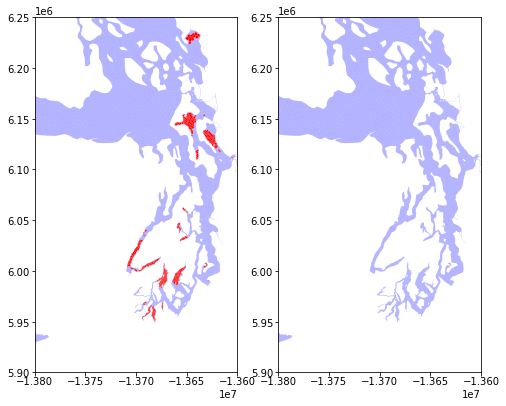

In [26]:
gdf['AreaNonCompliant_SK'] = comparison_df.SK_area * (comparison_df.SK_noncompliancedays>0)

fig, axs = plt.subplots(1,2, figsize = (8,8))
for idx in [0,1]:
    if idx==0:
        gdf_noncompliant = gdf.loc[
            (gdf['AreaNonCompliant']>0)
        ]
        gdf_good = gdf.loc[
            (gdf['AreaNonCompliant']==0)
        ]
    else:
        gdf_noncompliant = gdf.loc[
            (gdf['AreaNonCompliant_SK']>0)
        ]
        gdf_good = gdf.loc[
            (gdf['AreaNonCompliant_SK']==0)
        ]
    #~~~ Non-compliant (red) and Compliant (blue) nodes ~~~
    gdf_good.plot(ax=axs[idx],color='blue',legend=True,
                     label='Compliant', alpha=0.3)
    gdf_noncompliant.plot(ax=axs[idx],color='red',legend=True,
                     label=f'Non-compliant ($\Delta$DO < 0.25)')
    axs[idx].set_xlim([-1.38e7,-1.36e7])
    axs[idx].set_ylim([5.9e6, 6.25e6])

In [27]:
gdf['AreaNonCompliant_SK'].sum()

350.12364522700005

In [28]:
gdf['sk_idx']=((sknc_df.non_compliance_days>0) & (sknc_df.included_indicator==1))

<AxesSubplot:>

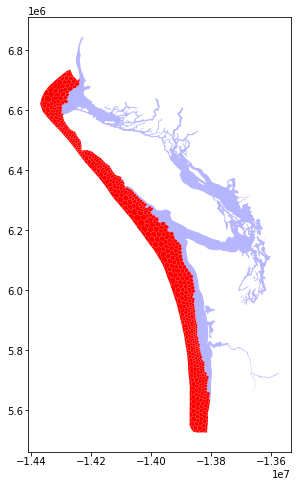

In [29]:
fig, axs = plt.subplots(1,1, figsize = (8,8))
gdf_noncompliant = gdf.loc[
    (gdf['sk_idx']==1)
]
gdf_good = gdf.loc[
    (gdf['sk_idx']==0)
]
    
gdf_good.plot(ax=axs,color='blue',legend=True,
                     label='Compliant', alpha=0.3)
gdf_noncompliant.plot(ax=axs,color='red',legend=True,
                 label=f'Non-compliant ($\Delta$DO < 0.25)')

#### I can't seem to line up these values correctly.  I am confidence about the way my nodes are being indexed because my noncompiant nodes appear in the right places; but I can't yet see what I'm doing wrong to line up SK's values